# Universal Bank Promotional Campaign: A practical illustration of *model performance assessment using confusion matrices*


### Authored by : Satya Srirama Siva Krishna Sanam

Impoting the required libraries

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from matplotlib import pyplot as plt

np.random.seed(42)

## Problem Statement

Universal Bank has begun a program to encourage existing customers to borrow via a consumer loan program. 

The bank has tested a loan promotion on a random sample of 5000 customers. This test promotion resulted in 480 of the 5000 existing customers accepting the offer. 

The bank is intrigued by the success of this promotion. It has hired you to help them develop a model to identify which of its remaining customers may accept a similar promotion. 

They hired you to help them reduce the promotion costs and target the offer to only a subset of its customers that or more likely to accept the offer. They disclosed that the cost to promote this offer is \\$10 dollars per customer, and the profit from obtaining a loan customer is \\$100. They have an additional 50,000 customers that have not been contacted about the promotion. 

## Preliminary business problem scoping

Before starting the analysis,jotting down what the profit and loss (P&L) must have been from their marking trial. Since they targeted every customer, they only have FP and TP.

In [49]:
TP_profit = 100 - 10   # the sale profit minus the targeting cost
TN_profit = 10 # they wouldn't take a loan, and we didn't spend the money targeting them
FP_profit = -10   # no loan profit, just the targeting cost
FN_profit = -100+10  # they would have taken the loan, but we didn't target them 

# in the null model there are only FP's and TP's because everyone is considered a possible customer
original_profit = 480*TP_profit + (5000-480)*FP_profit
print(f"${original_profit:,.2f}")

$-2,000.00


Using this approach on the remaining 50000 customers would not be a good business decision, as it would result in a loss of...

In [50]:
print(f"${original_profit*50000/5000:,.2f}")

$-20,000.00


Based on this initial analysis, it's clear that the bank cannot continue this promotion unless they have a model to help them identify the best potential customers. The best model possible would be 100% accurate. Universal Bank's initial test resulted in 480 or 5000 customers choosing to take the offer. The rate 480/5000 is, therefore, the expected rate of customers that take the request, and thus the expected profit result from a perfectly accurate model would be:

In [51]:
print(f"${(480*TP_profit+(5000-480)*TN_profit)*10:,.2f}")

$884,000.00


## Loading, Exploring and Cleaning the Data

In [52]:
# Loading the data direct from GitHub
df = pd.read_csv('https://raw.githubusercontent.com/prof-tcsmith/data/master/UniversalBank.csv') 
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


Checking column names, and for convenience, removing whitespaces...

In [53]:
df.columns

Index(['ID', 'Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal Loan', 'Securities Account',
       'CD Account', 'Online', 'CreditCard'],
      dtype='object')

In [54]:
df.columns = [s.strip().upper().replace(' ', '_') for s in df.columns] 
df.columns

Index(['ID', 'AGE', 'EXPERIENCE', 'INCOME', 'ZIP_CODE', 'FAMILY', 'CCAVG',
       'EDUCATION', 'MORTGAGE', 'PERSONAL_LOAN', 'SECURITIES_ACCOUNT',
       'CD_ACCOUNT', 'ONLINE', 'CREDITCARD'],
      dtype='object')

Dropping a couple of variables that aren't predictors and checking if there are any missing values in the remaining variables...

In [55]:
# drop ID, and Zip Code as predictors
df = df.drop(columns=['ID', 'ZIP_CODE'])

# checking for missing values
df.isnull().sum()

AGE                   0
EXPERIENCE            0
INCOME                0
FAMILY                0
CCAVG                 0
EDUCATION             0
MORTGAGE              0
PERSONAL_LOAN         0
SECURITIES_ACCOUNT    0
CD_ACCOUNT            0
ONLINE                0
CREDITCARD            0
dtype: int64

There are no missing values in the data as observed from the above output.

Checking the variable types

In [56]:
df.dtypes

AGE                     int64
EXPERIENCE              int64
INCOME                  int64
FAMILY                  int64
CCAVG                 float64
EDUCATION               int64
MORTGAGE                int64
PERSONAL_LOAN           int64
SECURITIES_ACCOUNT      int64
CD_ACCOUNT              int64
ONLINE                  int64
CREDITCARD              int64
dtype: object

In [57]:
df.SECURITIES_ACCOUNT.unique()

array([1, 0], dtype=int64)

In [58]:
df.CD_ACCOUNT.unique()

array([0, 1], dtype=int64)

In [59]:
df.ONLINE.unique()

array([0, 1], dtype=int64)

In [60]:
df.CREDITCARD.unique()

array([0, 1], dtype=int64)

In [61]:
df.PERSONAL_LOAN.unique()

array([0, 1], dtype=int64)

In [62]:
df.EDUCATION.unique()

array([1, 2, 3], dtype=int64)

In [63]:
df.describe()

,AGE,EXPERIENCE,INCOME,FAMILY,CCAVG,EDUCATION,MORTGAGE,PERSONAL_LOAN,SECURITIES_ACCOUNT,CD_ACCOUNT,ONLINE,CREDITCARD
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,45.338400,20.104600,73.774200,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,11.463166,11.467954,46.033729,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,23.000000,-3.000000,8.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,35.000000,10.000000,39.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,45.000000,20.000000,64.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,55.000000,30.000000,98.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,67.000000,43.000000,224.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


## Splitting and Normalizing the Data


In [64]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 

features = df.drop(columns=['PERSONAL_LOAN'])
target = df['PERSONAL_LOAN']

# splitting the data into validation and training set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)

# creating a standard scaler and fitting it to the training set of predictors
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

# Transforming the predictors of training and validation sets
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 

We observed low TP rate(2.7%) compared to the Original TP rate (9%) from our previous KNN analysis and concluded that it may have occurred due to the inherent data imbalance in our training data(480 in one class and 4520 in the other).To tackle this we will perform Random Under Sampling to acheive data balance in the training data to train our model.

In [65]:
#performing random under-sampling
from imblearn.under_sampling import RandomUnderSampler  #importing the required library

rus = RandomUnderSampler(random_state=1)
X_res, y_res = rus.fit_resample(X_train, y_train)

### SVC MODEL (Using a Linear Kernel)

In [66]:
# Initializing the model with a linear kernel
clf_linear = SVC(kernel='linear')
# Training the model
clf_linear.fit(X_res, y_res)
# Making predictions
y_pred_linear = clf_linear.predict(X_test)

In [67]:
# Accuracy
accuracy_linear = accuracy_score(y_test, y_pred_linear)
# Confusion Matrix
conf_matrix_linear = confusion_matrix(y_test, y_pred_linear)
# Classification Report
class_report_linear = classification_report(y_test, y_pred_linear)

print(f'Linear Kernel Accuracy: {accuracy_linear}')
print(f'Linear Kernel Confusion Matrix: \n{conf_matrix_linear}')
print(f'Linear Kernel Classification Report: \n{class_report_linear}')

Linear Kernel Accuracy: 0.8806666666666667
Linear Kernel Confusion Matrix: 
[[1190  161]
 [  18  131]]
Linear Kernel Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1351
           1       0.45      0.88      0.59       149

    accuracy                           0.88      1500
   macro avg       0.72      0.88      0.76      1500
weighted avg       0.93      0.88      0.90      1500



### SVC MODEL (Using a Non-Linear Kernel (RBF))

In [68]:
# Initializing the model with an RBF kernel
clf_rbf = SVC(kernel='rbf', probability=True)
# Training the model
clf_rbf.fit(X_res, y_res)
# Making predictions
y_pred_rbf = clf_rbf.predict(X_test)

In [69]:
# Accuracy
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
# Confusion Matrix
conf_matrix_rbf = confusion_matrix(y_test, y_pred_rbf)
# Classification Report
class_report_rbf = classification_report(y_test, y_pred_rbf)

print(f'RBF Kernel Accuracy: {accuracy_rbf: .4f}')
print(f'RBF Kernel Confusion Matrix: \n{conf_matrix_rbf}')
print(f'RBF Kernel Classification Report: \n{class_report_rbf}')

RBF Kernel Accuracy:  0.9200
RBF Kernel Confusion Matrix: 
[[1244  107]
 [  13  136]]
RBF Kernel Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1351
           1       0.56      0.91      0.69       149

    accuracy                           0.92      1500
   macro avg       0.77      0.92      0.82      1500
weighted avg       0.95      0.92      0.93      1500



In [70]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

In [71]:
y_pred_proba_svm = clf_rbf.predict_proba(X_test)[:,1] # calcualting probability values across different thresholds

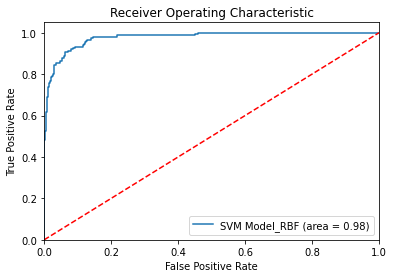

In [72]:
# ROC Curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_svm)

plt.figure()
plt.plot(fpr, tpr, label='SVM Model_RBF (area = %0.2f)' % roc_auc_score(y_test, y_pred_proba_svm))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [73]:
# Calculating AUC
auc = roc_auc_score(y_test, y_pred_proba_svm)
print("AUC Score: ", auc)

AUC Score:  0.9767857763823963


Using Non linear kernel values for our profit calculations since it's more accurate and has higher recall value than Linear Kernel function

 converting these values into percentages

In [74]:
confusion_perc_svc = conf_matrix_rbf/(.3 * 5_000)  # since the confusion matrix is for the performance on the test data, it's .30% of 5000, or 1500. 
confusion_perc_svc

array([[0.82933333, 0.07133333],
       [0.00866667, 0.09066667]])

Now, doing scaler multiplication of the number of customers that will be targetted in the newly proposed campaign (50,000 customers). This will give us the number of expected customers in each of the categories in the confusion matrix (TP, FP, TN, FN)

In [75]:
svc_result = confusion_perc_svc * 50_000
svc_result

array([[41466.66666667,  3566.66666667],
       [  433.33333333,  4533.33333333]])

creating a p_and_l matrix (profit and loss)

In [76]:
p_and_l_svc = np.array([[TN_profit, FP_profit],[FN_profit, TP_profit]])
p_and_l_svc

array([[ 10, -10],
       [-90,  90]])

Multiplying our profit and loss matrix with our svc_result matrix to get profit and loss associated with each of the catgories (FP, TP, FN, TN).To get the total profit,summing up all the p_and_l's for each category (TP, FP, TN, FN)

In [77]:
svc_model_profit = (svc_result * p_and_l_svc).sum()

print(f"${svc_model_profit:,.2f}")

$748,000.00


The expected Total Profit seems to be  $748,000.00 which is high compared to the Profit from KNN Model $582,000(from Universal bank problem KNN model). Its evident that the SVC is better model than KNN interms of almost every metric measure, but lets check further for Decision Tree Model.

### DECISION TREE MODEL


In [78]:
# Initializing and training the Decision Tree model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_res, y_res)
y_pred = clf.predict(X_test)

In [79]:
# Evaluating the model's performance
score = clf.score(X_test, y_test)
print(f"Model Accuracy: {score:.5f}")

Model Accuracy: 0.96267


In [80]:
# Accuracy
accuracy_DT = accuracy_score(y_test, y_pred)
# Confusion Matrix
conf_matrix_DT = confusion_matrix(y_test, y_pred)
# Classification Report
class_report_DT = classification_report(y_test, y_pred)

print(f'DT  Accuracy: {accuracy_DT}')
print(f'DT Confusion Matrix: \n{conf_matrix_DT}')
print(f'DT Classification Report: \n{class_report_DT}')

DT  Accuracy: 0.9626666666666667
DT Confusion Matrix: 
[[1304   47]
 [   9  140]]
DT Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1351
           1       0.75      0.94      0.83       149

    accuracy                           0.96      1500
   macro avg       0.87      0.95      0.91      1500
weighted avg       0.97      0.96      0.96      1500



In [81]:
y_pred_proba_DT = clf.predict_proba(X_test)[:,1]  # calcualting probability values across different thresholds

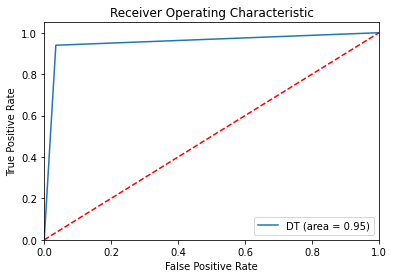

In [82]:
# ROC Curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_DT)

plt.figure()
plt.plot(fpr, tpr, label='DT (area = %0.2f)' % roc_auc_score(y_test, y_pred_proba_DT))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [83]:
# Calculating AUC
auc = roc_auc_score(y_test, y_pred_proba_DT)
print("AUC Score: ", auc)

AUC Score:  0.9524041351422511


converting these values into percentages

In [84]:
confusion_perc_DT = conf_matrix_DT/(.3 * 5_000)  # since the confusion matrix is for the performance on the test data, it's .30% of 5000, or 1500. 
confusion_perc_DT

array([[0.86933333, 0.03133333],
       [0.006     , 0.09333333]])

doing scaler multiplication of the number of customers that will be targetted in the newly proposed campaign (50,000 customers). This will give us the number of expected customers in each of the categories in the confusion matrix (TP, FP, TN, FN)

In [85]:
DT_result = confusion_perc_DT * 50_000
DT_result

array([[43466.66666667,  1566.66666667],
       [  300.        ,  4666.66666667]])

creating a p_and_l matrix (profit and loss)

In [86]:
p_and_l_DT = np.array([[TN_profit, FP_profit],[FN_profit, TP_profit]])
p_and_l_DT

array([[ 10, -10],
       [-90,  90]])

Multiplying our profit and loss matrix with our DT_result matrix to get profit and loss associated with each of the catgories (FP, TP, FN, TN).To get the total profit,summing up all the p_and_l's for each category (TP, FP, TN, FN)

In [87]:
DT_model_profit = (DT_result * p_and_l_DT).sum()

print(f"${DT_model_profit:,.2f}")

$812,000.00


## Discussion on comparision between SVC and DT Model in terms of performance

### Business Impact Summary

Universal bank's initial promotional campaign offered 5000 existing customers a loan product. of the 5000 targeted 480 have accepted the offer.Since the cost of targeting a customer is 10USD and the profit from taking the customer is 100USD,this initial trail resulted in a loss of 2000USD.If this null model is used for remaining 50000 customers it would result in a loss of 20000USD.

SVC RBF MODEL :

1.The expected total profit in this model is $748,000.<br>
2.It has an accuracy score of 92 percent which represents the model is able to predict correctly 92 customers out of 100 customers who are either willing or not willing to take a loan.<br>
3.Recall value is also 92 percent,which represents model is able to predict customers willing to take the loan correctly after marketing campaign i.e; reducing the false negative values.<br>
4. The area under curve for ROC curve is 0.98, which implies a better tradeoff between models ability to capture positive instances and controlling False postives.

Decision Tree Model :

1.The expected total profit is $812000.<br>
2.It has an accuracy score of 96.26%.which represents the model is able to predict correctly 96 customers out of 100 customers who are either willing or not willing to take a loan.<br>
3.Recall value is 95 percent,which represents model is able to predict customers willing to take the loan correctly after marketing campaign i.e; reducing the false negative values.<br>
4.Higher Profit in this model is because of the higher recall value of DT model, having less FN predictions compared to SVC model.<br>
5.The area under curve is 0.95 which is less than SVM model but False negatives has higher impact on our model so the profit is much higher in DT model.
Also the F1 score is much higher for the DT model compared to the SVC model,which maintains a good balance between Precision and accuracy.<br>

Based on the expected performance of the Decision Tree model, Universal Bank could proceed with implementing a more profitable campaign.Though we can't expect a perfect model to be found, there might be some room for improvement through Hyperparameter tuning.

